<a href="https://colab.research.google.com/github/sachinagnihotri/Natural-Language-Processing/blob/main/E3_Seniment_Analysis_Using_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#!pip install -q datasets

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import random
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
tf.keras.utils.set_random_seed(seed)
from tensorflow.keras import backend as K
K.clear_session()

# Parameters
max_words = 40000    # top 40k frequent words
max_len = 200        # pad/truncate reviews to 200 tokens
embedding_dim = 200  # embedding vector size

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

# Pad both train and test before concatenation
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# Combine for full dataset
x_full = np.concatenate((x_train, x_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

# Split validation data
val_size = 10000
x_val = x_full[:val_size]
y_val = y_full[:val_size]
x_train_full = x_full[val_size:]
y_train_full = y_full[val_size:]

print(f"Training samples: {len(x_train_full)}, Validation samples: {len(x_val)}")

# Common EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Training samples: 40000, Validation samples: 10000


In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Dot, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

# Attention-based Encoder-Decoder Model
def build_attention_model():
    inputs = Input(shape=(max_len,))

    # Embedding
    embedding = Embedding(max_words, embedding_dim, input_length=max_len)(inputs)

    # Bidirectional Encoder
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(256, return_sequences=True, return_state=True)
    )(embedding)

    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])

    # Decoder (single step for classification)
    decoder_lstm = LSTM(256 * 2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(encoder_outputs, initial_state=[state_h, state_c])

    # Attention Mechanism
    attention = Dot(axes=[2, 2])([decoder_outputs, encoder_outputs])  # (batch, seq, seq)
    attention = Activation('softmax')(attention)
    context = Dot(axes=[2, 1])([attention, encoder_outputs])  # weighted sum
    decoder_combined_context = Concatenate(axis=-1)([context, decoder_outputs])

    # Dense layers
    dense = Dense(128, activation='relu')(decoder_combined_context)
    dropout = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dropout[:, -1, :])  # last timestep for binary classification

    model = Model(inputs, output)

    optimizer = RMSprop(learning_rate=0.00005)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model




In [12]:
# Build and train model
attention_model = build_attention_model()
#attention_model.summary()

# Training
start_time = time.time()
history_attention = attention_model.fit(
    x_train_full, y_train_full,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
training_time = time.time() - start_time


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 135ms/step - accuracy: 0.5220 - loss: 0.6929 - val_accuracy: 0.5374 - val_loss: 0.6913
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.5824 - loss: 0.6779 - val_accuracy: 0.7989 - val_loss: 0.4452
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.8189 - loss: 0.4109 - val_accuracy: 0.8518 - val_loss: 0.3414
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.8691 - loss: 0.3160 - val_accuracy: 0.8697 - val_loss: 0.3086
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - accuracy: 0.8938 - loss: 0.2683 - val_accuracy: 0.8787 - val_loss: 0.2936
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.9098 - loss: 0.2356 - val_accuracy: 0.8807 - val_loss: 0.2844
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.9215 - loss: 0.2145 - val_accuracy: 0.8822 - val_loss: 0.2828
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.9303 - loss: 0

In [ ]:
# Plot Learning Curves
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_learning_curves(history_attention, "Attention Encoder–Decoder")


Attention Model Train Accuracy: 0.9417

Attention Model Test Accuracy: 0.9436
Training Time: 1458.93 seconds


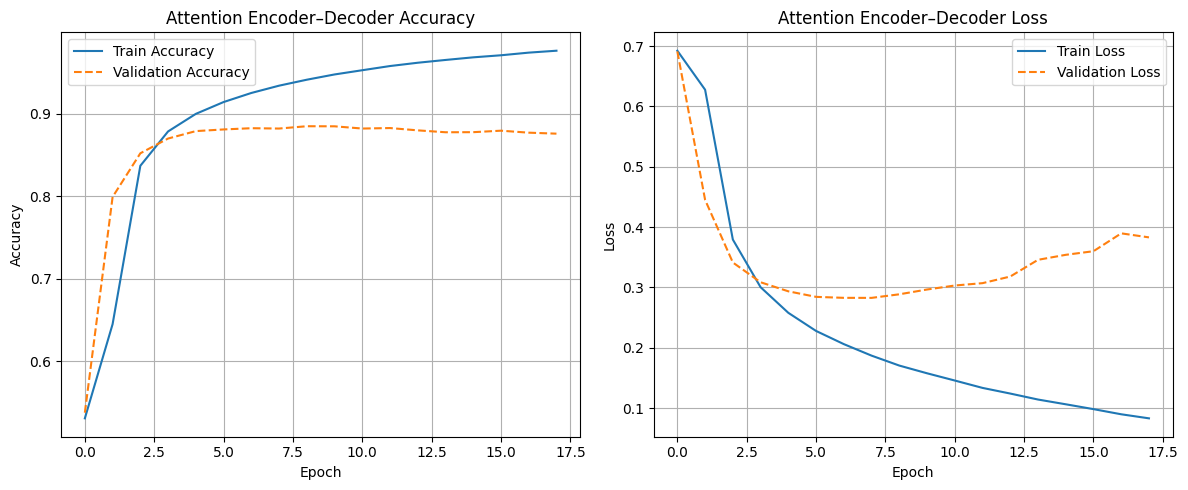

In [14]:
#Evaluation
train_loss, train_acc = attention_model.evaluate(x_train_full, y_train_full, verbose=0)
print(f"\nAttention Model Train Accuracy: {train_acc:.4f}")
test_loss, test_acc = attention_model.evaluate(x_test, y_test, verbose=0)
print(f"\nAttention Model Test Accuracy: {test_acc:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

